In [13]:
from typing import Annotated
from langchain_experimental.tools import PythonREPLTool, PythonAstREPLTool
import pandas as pd
import statsmodels as sm

df = pd.read_csv("HOUST.csv")
python_repl_tool = PythonAstREPLTool(locals={"df": df})

In [14]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            ( "system", system_prompt, ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

In [15]:
import functools

EDA_AGENT_TEMPLATE = """You are working with a pandas dataframe in Python. The name of the dataframe is `df`.
                It is important to understand the attributes of the dataframe before working with it. This is the result of running `df.head().to_markdown()`

                <df>
                {dhead}
                </df>

                You are not meant to use only these rows to answer questions - they are meant as a way of telling you about the shape and schema of the dataframe. 
                You also do not have use only the information here to answer questions - you can run intermediate queries to do exporatory data analysis to give you more information as needed. 
                Determine if the data is stationary by running an augmented dickey fuller test."""
template = EDA_AGENT_TEMPLATE.format(dhead=df.head().to_markdown())

llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18", temperature=0)

eda_agent = create_agent(llm, [python_repl_tool], system_prompt=template,)
eda_node = functools.partial(agent_node, agent=eda_agent, name="EDA")

In [16]:
import operator
from typing import Sequence, TypedDict

system_prompt = (
    """You are working with a pandas dataframe in Python. The name of the dataframe is `df`.
        It is important to understand the attributes of the dataframe before working with it. This is the result of running `df.head().to_markdown()`

        <df>
        {dhead}
        </df>

        You are not meant to use only these rows to answer questions - they are meant as a way of telling you about the shape and schema of the dataframe. 
        You also do not have use only the information here to answer questions - you can run intermediate queries to give you more information as needed."""
)

# MessagesPlaceholder(variable_name="messages"),

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        (
            "human",
            "Using the data in the dataframe `df` and the package statsmodels"
            "First generate an ACF plot, display it and save it to 'acf.png' "
            "Then generate a PACF plot, display it and save it to 'pacf.png'",
        ),
    ]
).format(dhead=df.head().to_markdown())

# ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
acf_agent = create_agent(llm, [python_repl_tool], system_prompt=prompt,)
acf_node = functools.partial(agent_node, agent=acf_agent, name="Autocorrelation")

In [17]:
import base64

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

In [18]:
from langchain_core.prompts import HumanMessagePromptTemplate

system_prompt = (
    "Analyze the plot."
)

image_path = 'path/to/image.png'

pacf_prompt_template = ChatPromptTemplate.from_messages(
    messages=[
        ("system", 'This plot contains the partial autocorrelation function from a time series, based on the plot what AR and MA terms should be considered when modeling this time series?'),
        HumanMessagePromptTemplate.from_template([{'image_url': {'path': 'pacf.png'}}])
    ]
)

# pacf_prompt = chat_prompt_template.format(image_path='pacf.png')

acf_prompt_template = ChatPromptTemplate.from_messages(
    messages=[
        ("system", "This plot contains the autocorrelation function from a time series, based on the plot what AR and MA terms should be considered when modeling this time series?"),
        HumanMessagePromptTemplate.from_template([{'image_url': {'path': 'acf.png'}}])
    ]
)

# acf_prompt = chat_prompt_template.format(image_path='acf.png')

pacf_plot_agent = create_agent(llm, [python_repl_tool], system_prompt=pacf_prompt_template.format(),)
pacf_plot_node = functools.partial(agent_node, agent=pacf_plot_agent, name="PACF analysis")

acf_plot_agent = create_agent(llm, [python_repl_tool], system_prompt=acf_prompt_template.format(),)
acf_plot_node = functools.partial(agent_node, agent=acf_plot_agent, name="ACF analysis")

In [19]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str

memory = MemorySaver()

workflow = StateGraph(AgentState)
workflow.add_node("EDA", eda_node)
workflow.add_node("Autocorrelation", acf_node)
workflow.add_node("ACF analysis", acf_plot_node)
workflow.add_node("PACF analysis", pacf_plot_node)

workflow.add_edge(START, "EDA")
workflow.add_edge("EDA", "Autocorrelation")
workflow.add_edge("Autocorrelation", "ACF analysis")
workflow.add_edge("ACF analysis", "PACF analysis")
workflow.add_edge("PACF analysis", END)

graph = workflow.compile(checkpointer=memory)

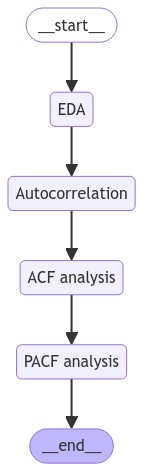

In [20]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

{'EDA': {'messages': [HumanMessage(content='The results of the Augmented Dickey-Fuller test are as follows:\n\n- Test Statistic: -3.7981\n- p-value: 0.0029\n- Number of Lags: 15\n- Number of Observations: 761\n- Critical Values:\n  - 1%: -3.4389\n  - 5%: -2.8653\n  - 10%: -2.5688\n- AIC: 9204.4705\n\n### Interpretation:\n- The null hypothesis of the Augmented Dickey-Fuller test is that the time series has a unit root, meaning it is non-stationary.\n- Since the p-value (0.0029) is less than the common significance levels (0.01, 0.05, and 0.10), we reject the null hypothesis.\n- Additionally, the test statistic (-3.7981) is less than the critical values at all levels, further supporting the conclusion.\n\n### Conclusion:\nThe data is stationary.', name='EDA')]}}
----


<Figure size 1000x500 with 0 Axes>

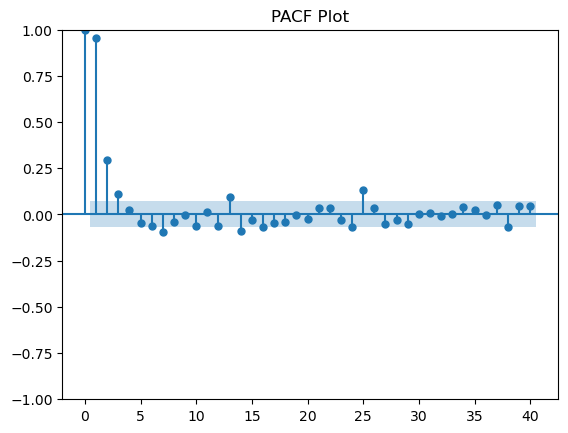

<Figure size 1000x500 with 0 Axes>

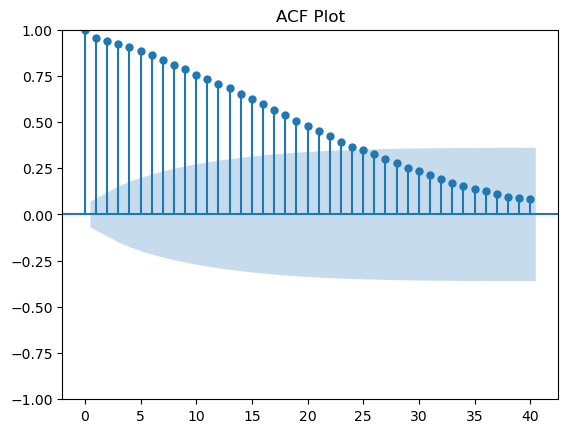

<Figure size 1000x500 with 0 Axes>

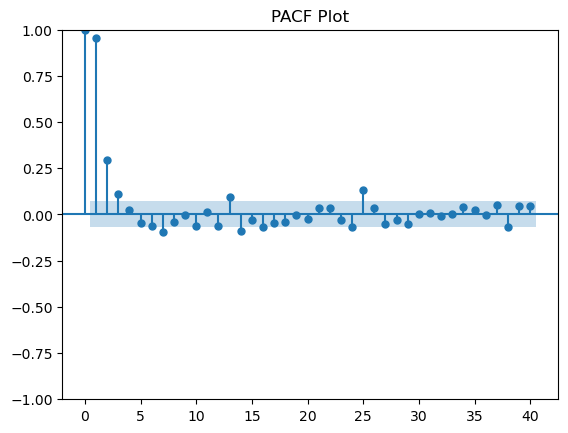

{'Autocorrelation': {'messages': [HumanMessage(content="The ACF and PACF plots have been successfully generated and saved as 'acf.png' and 'pacf.png', respectively. If you need any further analysis or assistance, feel free to ask!", name='Autocorrelation')]}}
----


KeyError: 'Input to ChatPromptTemplate is missing variables {"\'type\'"}.  Expected: ["\'type\'", \'agent_scratchpad\', \'messages\'] Received: [\'messages\', \'next\', \'intermediate_steps\', \'agent_scratchpad\']'

In [21]:
config = {"configurable": {"thread_id": "1"}}

for s in graph.stream({"messages": [HumanMessage(content="Run the analysis")]}, config):
    if "__end__" not in s:
        print(s)
        print("----")

In [23]:
graph.get_state(config)
# sys.exit()

StateSnapshot(values={'messages': [HumanMessage(content='Run the analysis'), HumanMessage(content='The results of the Augmented Dickey-Fuller test are as follows:\n\n- Test Statistic: -3.7981\n- p-value: 0.0029\n- Number of Lags: 15\n- Number of Observations: 761\n- Critical Values:\n  - 1%: -3.4389\n  - 5%: -2.8653\n  - 10%: -2.5688\n- AIC: 9204.4705\n\n### Interpretation:\n- The null hypothesis of the Augmented Dickey-Fuller test is that the time series has a unit root, meaning it is non-stationary.\n- Since the p-value (0.0029) is less than the common significance levels (0.01, 0.05, and 0.10), we reject the null hypothesis.\n- Additionally, the test statistic (-3.7981) is less than the critical values at all levels, further supporting the conclusion.\n\n### Conclusion:\nThe data is stationary.', name='EDA'), HumanMessage(content="The ACF and PACF plots have been successfully generated and saved as 'acf.png' and 'pacf.png', respectively. If you need any further analysis or assistanc

In [ ]:
import base64
import requests
import os

# make this into a function then into a tool

def analyze_image():
  def encode_image(image_path):
      with open(image_path, "rb") as image_file:
          return base64.b64encode(image_file.read()).decode('utf-8')
      
  OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

  headers = {
      "Content-Type": "application/json",
      "Authorization": f"Bearer {OPENAI_API_KEY}"
  }

  payload = {
      "model": "gpt-4o-mini-2024-07-18",
      "messages": [
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": "This plot contains the partial autocorrelation from a time series, what lags show autocorrelation that should be included in an ARMA model?"
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{encode_image('pacf.png')}"
              }
            }
          ]
        }
      ],
      "max_tokens": 300
  }

  response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

  return response.json()

# r = analyze_image()

{'id': 'chatcmpl-9oWtx4ucR3i63cnxUkguizRjAetgU',
 'object': 'chat.completion',
 'created': 1721829901,
 'model': 'gpt-4o-mini-2024-07-18',
 'choices': [{'index': 0,
   'message': {'role': 'assistant',
    'content': 'To determine if the residuals are autocorrelated using the provided PACF plot, we look for spikes that cross the significance bounds (the shaded area). \n\n1. **Initial Spikes**: The first few lags (up to around lag 5) show significant positive values, indicating potential autocorrelation at those lags.\n  \n2. **Subsequent Lags**: Most of the remaining lags fluctuate around zero and remain within the confidence bounds.\n\n### Conclusion:\nThe PACF plot suggests that there is some indication of autocorrelation in the residuals, particularly in the first few lags. Further analysis and perhaps a different diagnostic check (like the ACF plot or a statistical test) may be warranted to understand the residuals better.'},
   'logprobs': None,
   'finish_reason': 'stop'}],
 'usag

In [24]:

# ok so here is where I'm at
# sorting out the templates for my agents to work with
# even the ones above may not be working quite right due to the errors

from langchain_core.prompts import HumanMessagePromptTemplate, ChatPromptTemplate
from langchain_core.messages import HumanMessage

image_path = 'pacf.png'
detail_parameter = 'high'


def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            ( "system", system_prompt, ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor


acf_prompt_template = ChatPromptTemplate.from_messages(
    messages=[
        ("system", "This plot contains the autocorrelation function from a time series, based on the plot what AR and MA terms should be considered when modeling this time series?"),
        HumanMessagePromptTemplate.from_template([{'image_url': {'path': 'acf.png'}}])
    ]
)


chat_prompt_template = ChatPromptTemplate.from_messages(
    [
        HumanMessage(content='This plot contains the partial autocorrelation function from a time series, based on the plot what AR and MA terms should be considered when modeling this time series?'),
        HumanMessagePromptTemplate.from_template(
            [{'image_url': {'path': '{image_path}', 'detail': '{detail_parameter}'}}]
        )
    ]
)

prompt = chat_prompt_template.format(image_path=image_path, detail_parameter=detail_parameter)

# agent = create_openai_tools_agent(llm, tools, prompt)
# executor = AgentExecutor(agent=agent, tools=tools)

pacf_plot_agent = create_agent(llm, [python_repl_tool], system_prompt=prompt,)
pacf_plot_agent.invoke({"input": "Run the analysis"})

KeyError: 'Input to ChatPromptTemplate is missing variables {\'messages\', "\'type\'"}.  Expected: ["\'type\'", \'agent_scratchpad\', \'messages\'] Received: [\'input\', \'intermediate_steps\', \'agent_scratchpad\']'